# Assignment - Week 3

Eq. (30) and (32) from the [paper](https://arxiv.org/pdf/2011.10395)

## Observations
1. exp features are more difficult to map than polynomial or sinusoidal (when using Chebyshev)
2. ChebT much more expressive but slower to train so optimize suitably
3. **more expressive maps/ansatzes require smaller bdry wgts**
4. **more qubit/depth circuit require smaller lr, due to high dimensionality of parameter space**
5. EvEn maps help but not a lot, try varying tau, H ??? *investigate*
6. 

In [59]:
import torch
# DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# torch.set_default_device(DEVICE)
print(f'Using device: {torch.get_default_device()}, dtype: {torch.get_default_dtype()}')

import qadence as qd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from types import FunctionType as function

sns.set_theme(style="whitegrid", context="talk", palette="deep")
colors = ["#f29c11", "#1198f2", "#2bbd4e", "#decf47", "#ca68e3"]
custom_palette = sns.color_palette(colors)

%matplotlib inline

Using device: cpu, dtype: torch.float64


In [60]:
# Utility functions
mse_loss = torch.nn.MSELoss()


def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(inputs),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad

def train_model(model: qd.QuantumModel, x_train, x0, u0, n_epochs, lr, loss_fn, mode, n_qubits, cost_obs, from_dict = None):
    # take parameters and observable from given model's `.to_dict()` output
    if from_dict is not None:
        # TODO: strict=False for preventing errors from irrelevant parameters not being present?
        model.load_params_from_dict(from_dict, strict=False)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,)
    
    # Add learning rate scheduler (DISABLED FOR NOW)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=50
    )
    
    loss_hist, score_hist = np.empty(n_epochs), np.empty(n_epochs)
    
    # compute constant `factor` for identity operator to add for getting close to u0
    # in case of pinned boundary handling, as: (u0 - f(x0))
    # and add to observable
    if mode == 'pinned':
        identity = qd.I(0)
        for i in range(1, n_qubits):
            identity @= qd.I(i)
        factor = (u0 - model(x0)).detach()
        scalar = identity * factor
        print(f'factor (alpha) for cost obs = {factor.item()}')
        observable = cost_obs + scalar
        observable = model.observable(observable, n_qubits)  # convert acc to model
        model._observable = [observable]  # set
        print(f'f(x0) = {model(x0).detach().item()}')

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Compute loss
        loss, score, shift = loss_fn(inputs=x_train)
        
        # Gradient clipping (DISABLED FOR NOW)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
        
        # Update learning rate (DISABLED FOR NOW)
        # scheduler.step(loss)
        
        loss_hist[epoch] = loss.item()
        score_hist[epoch] = score
            
        # if (epoch + 1) % 10 == 0:
        #     print(f'[{epoch+1}] lr={scheduler.get_last_lr()[0]:.3e}')

    return loss_hist, score_hist


def plot_results(results, labels, x_test, solution):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    true_solution = solution(x_test.detach())
    
    assert len(results) == len(labels)
    
    ax2.plot(x_test, true_solution, label=r"$u(x)$", linewidth=3, color = colors[0])
    
    for i, ((model, loss_hist, score_hist, _, shift_var, _), label) in enumerate(zip(results, labels)):
        f_x = model(x_test).flatten().detach() + shift_var.detach().item()
        color = colors[(i + 1) % len(colors)]

        ax2.plot(x_test, f_x, label=label, linestyle='--', linewidth=2, color=color)
        # plot L_F, L_Q resp.
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label=r"$\mathit{L_F}\;$" + label, linewidth = 2, color=color)
        ax1.plot(np.arange(len(score_hist)), score_hist, label=r"$\mathit{L_Q}\;$" + label, linestyle='--', linewidth = 2, color=color)
        ax1.set_yscale('log')
        
    ax1.legend()
    ax2.legend()
    ax2.grid(True)
    ax1.grid(True)
    
    ax1.set_xlabel(r"$n_j$")
    ax1.set_ylabel("Loss")
    
    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$f(x)$")
    
    fig.tight_layout()
    # plt.show()

# QNN configuration
def create_qnn_model(n_qubits: int, depth: int, fm_type: qd.BasisSet, scaling: qd.ReuploadScaling, n_layers: int, cost_obs: qd.AbstractBlock, mode: str, hamevo = None):
    fm_layer = qd.feature_map(
        n_qubits=n_qubits,
        param="x",
        fm_type=fm_type,
        op=qd.RY,
        reupload_scaling=scaling,
    )
    fm = qd.tag(qd.chain(fm_layer for _ in range(n_layers)), "feature_map")
    
    # define hamiltonian evolution (if defined)
    # assuming `hamevo[0]` is the unitary hamiltonian exponential generator and `hamevo[1]` the time constant
    # using constant preset time here
    if hamevo is not None:
        hamevo = qd.HamEvo(hamevo[0], torch.tensor([hamevo[1]]))
        fm = qd.chain(fm, qd.tag(hamevo, "EvEn_map"))
    
    ansatz = qd.hea(n_qubits=n_qubits, depth=depth, operations=[qd.RZ, qd.RX, qd.RZ])
    
    circuit = qd.QuantumCircuit(n_qubits, qd.chain(fm, ansatz))
    
    model = qd.QNN(circuit=circuit, observable=cost_obs, inputs=["x"])
    
    # initialize parameters with slightly larger range [0, 2pi / 10)
    model.reset_vparams(torch.rand(model.num_vparams) * 2 * torch.pi / 10)
    
    # [circuit, model,] in pinned, [circuit,mode,shift_var] in floating
    ret = [circuit, model]
    
    if mode == 'floating':
        # define as tensor without optimization
        f_b = torch.tensor(0.0, requires_grad=False)
        ret.append(f_b)
    
    return ret

# General subroutine for loss function
def create_loss_fn(functional, solution_fn, x_train, model: torch.nn.Module, x0: float, u0: float, mode: str, boundary_loss_weight: float = 0, shift_var: torch.Tensor = None):
    # compute solution for score calculation
    u_x = solution_fn(x_train.detach()).detach()
    
    def floating_loss_fn(inputs: torch.Tensor) -> torch.Tensor:
        # update the boundary shift f_b manually
        nonlocal shift_var
        with torch.no_grad():
            f_old_x0 = model(x0).detach().item()
            # dont reset only *update*
            shift_var -= shift_var
            shift_var += (u0 - f_old_x0)
            # print(f'f_b = {shift_var}, f_old_x0 = {f_old_x0}')
    
        f_x = (model(inputs) + shift_var)
        # print(f'f_x0 = {f_x.squeeze()[0]}')
        df_dx = calc_deriv(f_x, inputs)

        diff_loss = torch.mean((functional(df_dx, f_x, inputs)) ** 2)
        
        score = mse_loss(f_x, u_x).detach().item()

        return diff_loss, score, shift_var.item()
    
    
    def pinned_loss_fn(inputs: torch.Tensor) -> torch.Tensor:
        f_x = model(inputs)
        df_dx = calc_deriv(f_x, inputs)

        diff_loss = torch.mean((functional(df_dx, f_x, inputs)) ** 2)

        f_x0 = model(x0)
        wgtd_bdry_loss = boundary_loss_weight * (f_x0 - u0) ** 2
        
        print(f'diff_loss={diff_loss.item()}, wgtd_bdry_loss={wgtd_bdry_loss.item()}')

        score = mse_loss(f_x, u_x).detach().item()
        
        return diff_loss + wgtd_bdry_loss, score, 0.0

    if mode == 'pinned':
        return pinned_loss_fn
    if mode == 'floating':
        return floating_loss_fn

# General workflow for solver
def run_dqc_solver(
    functional,
    u0: float,
    solution_fn,
    fm_type: qd.BasisSet,
    scaling: qd.ReuploadScaling,
    n_layers: int,
    n_qubits: int,
    depth: int,
    cost_obs: qd.AbstractBlock,
    xmin: float,
    xmax: float,
    n_points: int,
    x0: float,
    mode: str,
    n_epochs: int,
    lr: float,
    boundary_loss_weight: float = 0.0,  # only defined if `mode = 'pinned'`,
    from_dict = None,  # take parameters from given model's `.to_dict()` output
    hamevo = None  # hamiltonian evolution
):
    # Training data
    # uniform
    x_train = torch.linspace(xmin, xmax, n_points, requires_grad=True).unsqueeze(1)
    # random
    # x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)

    # Model
    circuit, model, *extra = create_qnn_model(
        n_qubits=n_qubits,
        depth=depth,
        fm_type=fm_type,
        n_layers=n_layers,
        cost_obs=cost_obs,
        scaling=scaling,
        mode=mode,
        hamevo=hamevo
    )
    shift_var = None
    if mode == 'floating':
        shift_var = extra[0]

    # Loss function
    x0_tensor = torch.tensor([x0]).unsqueeze(1)
    loss_fn = create_loss_fn(
        functional=functional,
        solution_fn=solution_fn,
        x_train=x_train,
        model=model,
        x0=x0_tensor,
        u0=u0,
        mode=mode,
        boundary_loss_weight=boundary_loss_weight,
        shift_var=shift_var
    )

    # Train
    loss_hist, score_hist = train_model(
        model=model,
        x_train=x_train,
        x0=x0_tensor,
        u0=u0,
        n_epochs=n_epochs,
        lr=lr,
        loss_fn=loss_fn,
        mode=mode,
        n_qubits=n_qubits,
        cost_obs=cost_obs,
        from_dict=from_dict
    )

    # Final loss
    x_test = torch.arange(xmin, xmax, step=0.01).unsqueeze(1)
    if shift_var is None:
        shift_var = torch.tensor([0.0], requires_grad=False).unsqueeze(1)
        
    f_x = model(x_test).flatten().detach() + shift_var.item()
    u_x = solution_fn(x_test).flatten()

    final_score = torch.nn.MSELoss()(u_x, f_x).item()
    print(f"score:", final_score)

    return model, loss_hist, score_hist, final_score, shift_var, circuit


## 1. Solving eq(30)
Define functional and solution corresponding to eq(30):

$$
\frac{du}{dx} + \lambda u (\kappa + \tan(\lambda x)) = 0, \quad u(0) = u_0
$$

Using $\lambda = 8, \kappa = 0.1, u_0 = 1$. (using `a, k, u0` variable names)

Solution: $u(x) = u_0 e^{-\lambda \kappa x} \cos(\lambda x)$

### Observations:
1. Best: `pinned, .01`
2. too many points leads to poor optimization and overfitting
3. too many qubits drastically slows down training BUT increases expressibility and betters accuracy
4. higher depth increases training time but betters accuracy
5. `lr` from `1e-3` to `1e-2` are suitable
6. `pinned` mode gives consistent loss decay as opposed to `floating`

In [92]:
# define functional and solution (if known)
a = 8
k = 0.1
u0_eq30 = 1

def functional_eq30(du_dx, u, x):
    return du_dx + a * u * (k + torch.tan(a * x))

def solution_eq30(x):
    return u0_eq30 * torch.exp(-a * k * x) * (torch.cos(a * x))

xmin, xmax, n_points = 0.0, 0.9, 20
x0_eq30 = 0.0

n_qubits, depth = 6, 6
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)
n_layers = 1
bdry_loss_wgts = 5e1, 1e-3

n_epochs = 1200
lr = 0.01

### 1A. Using (sparse) chebyshev map

In [95]:
torch.manual_seed(4)

cheb_eq30_p = run_dqc_solver(
    functional = functional_eq30,
    u0 = u0_eq30,
    solution_fn = solution_eq30,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2,
    n_layers = n_layers,
    n_qubits = n_qubits,
    depth = depth,
    cost_obs = cost_obs,
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq30,
    boundary_loss_weight = bdry_loss_wgts[0],
    n_epochs = n_epochs,
    lr = 0.01,
    mode = 'pinned'
)

factor (alpha) for cost obs = 2.6327532367813906
f(x0) = 0.9999999999999994
diff_loss=3543.621302127433, wgtd_bdry_loss=1.5407439555097887e-29
diff_loss=3116.283131945497, wgtd_bdry_loss=0.27746759353064704
diff_loss=2744.5003031037336, wgtd_bdry_loss=1.0690962758271714
diff_loss=2421.6375441807095, wgtd_bdry_loss=2.309503672397226
diff_loss=2142.298558565715, wgtd_bdry_loss=3.9347203373004125
diff_loss=1900.9808449638426, wgtd_bdry_loss=5.88685576916743
diff_loss=1692.933175324683, wgtd_bdry_loss=8.109155116119922
diff_loss=1514.1146403816183, wgtd_bdry_loss=10.54209764873195
diff_loss=1360.96694606057, wgtd_bdry_loss=13.121570596772886
diff_loss=1230.2819639028457, wgtd_bdry_loss=15.778792834564333
diff_loss=1119.11787892172, wgtd_bdry_loss=18.44053695734111
diff_loss=1024.7246198425203, wgtd_bdry_loss=21.030388246560676
diff_loss=944.503397469732, wgtd_bdry_loss=23.471484648146472
diff_loss=876.0145133655293, wgtd_bdry_loss=25.6901016892095
diff_loss=817.0119315584732, wgtd_bdry_los

### 1B. Using chebyshev tower map
Loss plateaus around $1$.

In [32]:
torch.manual_seed(4)

chebT_eq30_p = run_dqc_solver(
    functional = functional_eq30,
    u0 = u0_eq30,
    solution_fn = solution_eq30,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = n_layers,
    n_qubits = n_qubits,
    depth = depth,
    cost_obs = cost_obs,
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq30,
    boundary_loss_weight = bdry_loss_wgts[1],
    n_epochs = n_epochs,
    lr =  lr,
    mode = 'pinned'
)

factor (alpha) for cost obs = 1.062646187926268
f(x0) = 1.0000000000000004
diff_loss=1076.3968111938939, wgtd_bdry_loss=1.9721522630525296e-34
diff_loss=836.4225492006253, wgtd_bdry_loss=2.2750712487392005e-06
diff_loss=627.8842685225574, wgtd_bdry_loss=7.464245788588372e-06
diff_loss=452.6886150300171, wgtd_bdry_loss=1.3821619480390845e-05
diff_loss=311.65698801772066, wgtd_bdry_loss=2.0464548352559224e-05
diff_loss=204.23588046802882, wgtd_bdry_loss=2.686899060929038e-05
diff_loss=128.4156252238252, wgtd_bdry_loss=3.2763275001316543e-05
diff_loss=80.81159752487984, wgtd_bdry_loss=3.817354517207716e-05
diff_loss=56.8499959203024, wgtd_bdry_loss=4.3402210707678975e-05
diff_loss=50.78702341002155, wgtd_bdry_loss=4.888328175510035e-05
[10] lr=1.000e-02

diff_loss=55.8371095056713, wgtd_bdry_loss=5.496155026494559e-05
diff_loss=64.91534234295973, wgtd_bdry_loss=6.172585120043674e-05
diff_loss=72.03048562403357, wgtd_bdry_loss=6.904143253117297e-05
diff_loss=73.60896587909392, wgtd_bdry_lo

### Results

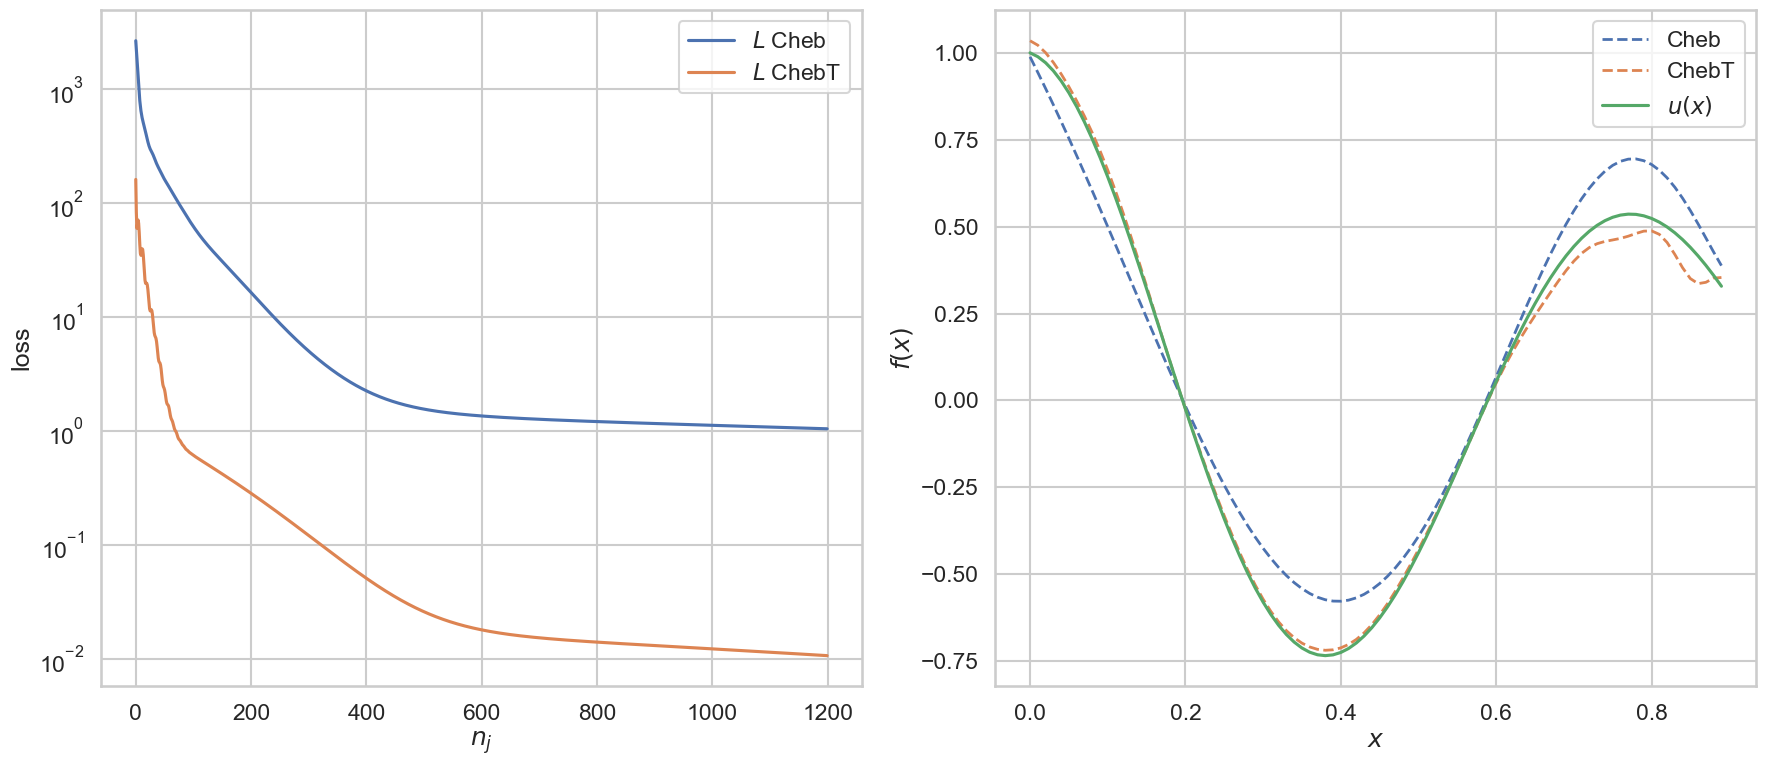

In [ ]:
x_test = torch.arange(xmin, xmax, step=0.01).unsqueeze(1)

plot_results(
    results = [cheb_eq30_p, chebT_eq30_p],
    labels = ['Cheb', 'ChebT'],
    x_test = x_test,
    solution = solution_eq30
)

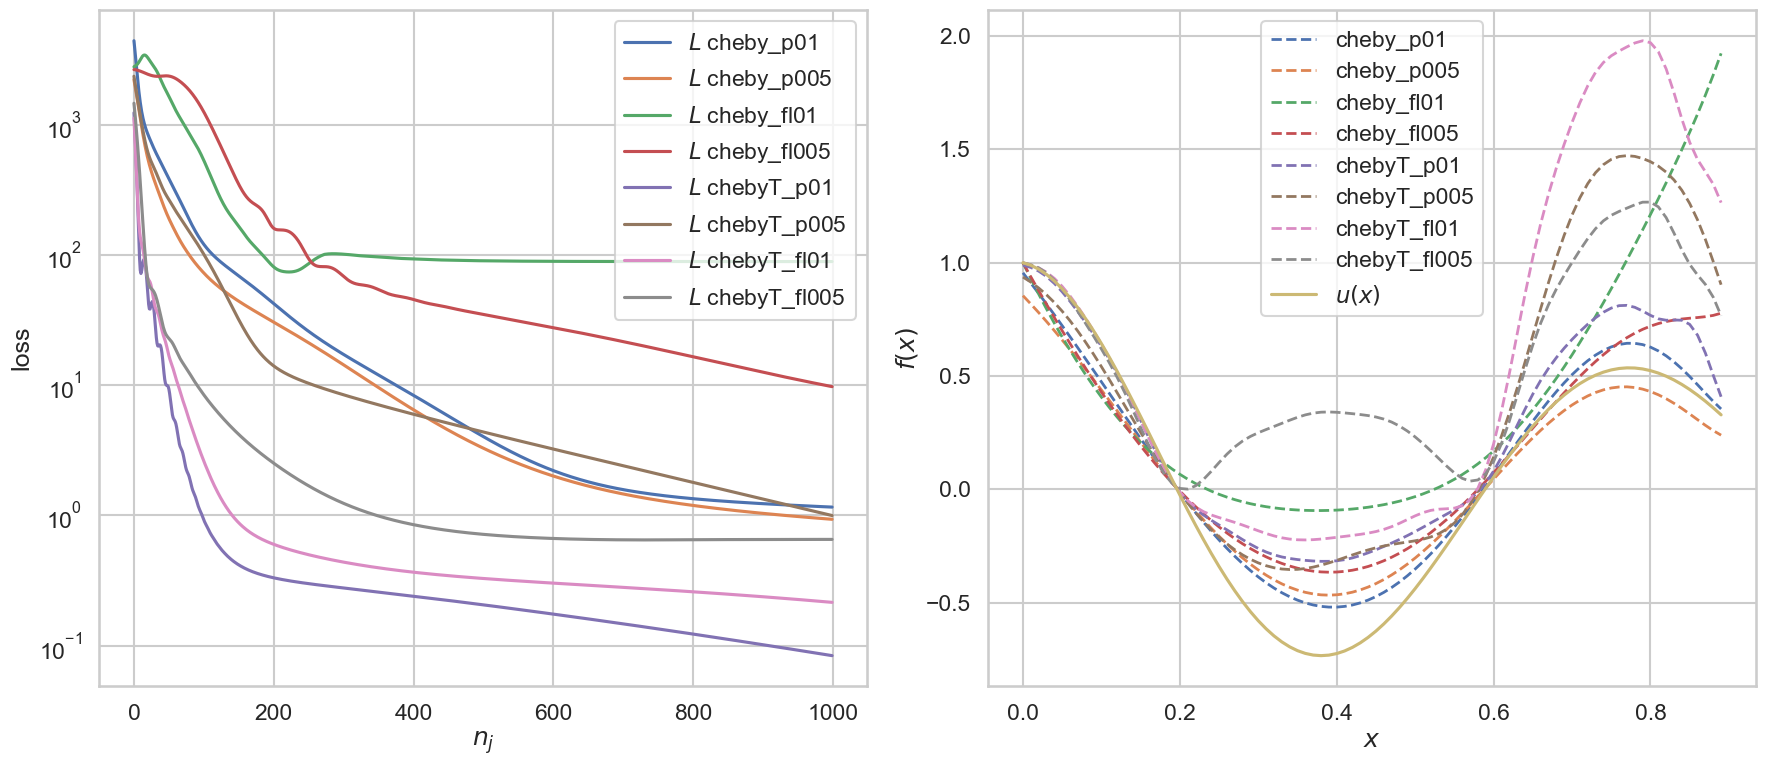

In [ ]:
# KEEP FOR REFERENCE

## 2. Solving eq(32)
Define functional and solution corresponding to eq(32):
$$
    \frac{du}{dx} - 4u + 6u^2 - \sin(50x) - u\cos(25x) + \frac{1}{2} = 0, \quad u(0) = u_0
$$

Using $u_0 = 75$

A numerical solution is presented (as a function) below for comparison

### Observation
(same as above +)
1. higher qubit count / depth is best matched with lesser lr like N=6, lr=1e-2 or N=8, lr=1e-3
2. EvEn feature map increases expressibility. soln takes longer to converge and there's some initial problems in optimization
   but final soln is better
3. did not see huge benefit from EvEn so investigate further... experiment with `tau` maybe variationally.... maybe time-dependent hamiltonians
4. more expressive structures require smaller boundary weights!!!

In [86]:
# define functional and solution (if known)
u0_eq32 = 0.75
x0_eq32 = 0.0

def functional_eq32(du_dx, u, x):
    return du_dx - 4 * u + 6 * u**2 - torch.sin(50 * x) - u * torch.cos(25 * x) + 0.5

def solution_eq32(inputs: torch.Tensor, x_start=0, x_end=10, num_points=5000):
    # Define the function to compute du/dx
    def rhs(u, x):
        return 4 * u - 6 * u**2 + torch.sin(50 * x) + u * torch.cos(25 * x) - 0.5

    # Generate x values for solving the ODE
    x = torch.linspace(x_start, x_end, num_points, dtype=torch.float64)
    dx = (x_end - x_start) / (num_points - 1)

    # Initial condition
    u = torch.zeros(num_points, dtype=torch.float64)
    u[0] = u0_eq32

    # Solve the ODE using the explicit Euler method
    for i in range(num_points - 1):
        u[i + 1] = u[i] + dx * rhs(u[i], x[i])

    # Interpolate the solution at the input points
    u_at_inputs = torch.from_numpy(np.interp(inputs.numpy(), x.numpy(), u.numpy()))

    return u_at_inputs

xmin, xmax, n_points = 0.0, 0.9, 100

n_qubits = 8

In [87]:
# N = 8, D = 12, epochs = 1000, wgt = 1e1, lr = 0.001, score = 5.2e-5, time = 9m

torch.manual_seed(1)
eq32_12 = run_dqc_solver(
    functional = functional_eq32,
    u0 = u0_eq32,
    solution_fn = solution_eq32,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = 1,
    n_qubits = n_qubits,
    depth = 12,
    cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z),
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq32,
    boundary_loss_weight = 1e1,
    n_epochs = 1000,
    lr = 0.001,
    mode = 'pinned'
)

factor (alpha) for cost obs = 0.6665684806895903
f(x0) = 0.7499999999999977
diff_loss=31.51772470101166, wgtd_bdry_loss=5.435744675038534e-29
diff_loss=29.659185494229188, wgtd_bdry_loss=2.8241638568793894e-05
diff_loss=27.86569975492496, wgtd_bdry_loss=0.00011026700210903684
diff_loss=26.140274949394065, wgtd_bdry_loss=0.00022672546720209846
diff_loss=24.4849175494086, wgtd_bdry_loss=0.0003506223696486405
diff_loss=22.90145974598767, wgtd_bdry_loss=0.000469344340185066
diff_loss=21.39175186854702, wgtd_bdry_loss=0.000579903143698962
diff_loss=19.95729471085682, wgtd_bdry_loss=0.0006803704450860781
diff_loss=18.599076503288966, wgtd_bdry_loss=0.0007695909935669695
diff_loss=17.317497214750677, wgtd_bdry_loss=0.000847627641444947
diff_loss=16.112322272368445, wgtd_bdry_loss=0.0009157895241650883
diff_loss=14.982664809209462, wgtd_bdry_loss=0.0009762749988000153
diff_loss=13.926996488832483, wgtd_bdry_loss=0.0010315618232101603
diff_loss=12.94318409277127, wgtd_bdry_loss=0.00108386284350

In [88]:
# N = 8, D = 6, epochs = 1000, wgt = 1e1, lr = 0.001, score = 6e-4, time = 12.5m

torch.manual_seed(1)
eq32_6 = run_dqc_solver(
    functional = functional_eq32,
    u0 = u0_eq32,
    solution_fn = solution_eq32,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = 1,
    n_qubits = n_qubits,
    depth = 6,
    cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z),
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq32,
    boundary_loss_weight = 5e1,
    n_epochs = 1000,
    lr =  0.001,
    mode = 'pinned'
)

factor (alpha) for cost obs = 0.8353680881935658
f(x0) = 0.749999999999998
diff_loss=49.36572115784009, wgtd_bdry_loss=1.9968041663406861e-28
diff_loss=48.40132531920768, wgtd_bdry_loss=4.1416594751557695e-06
diff_loss=47.44851731903159, wgtd_bdry_loss=1.6530447665487842e-05
diff_loss=46.50773163497202, wgtd_bdry_loss=3.6999071689207165e-05
diff_loss=45.57932675742423, wgtd_bdry_loss=6.517154193919971e-05
diff_loss=44.66360421316026, wgtd_bdry_loss=0.00010037304328663394
diff_loss=43.76087313343607, wgtd_bdry_loss=0.00014153811638361802
diff_loss=42.87144518795737, wgtd_bdry_loss=0.0001871714030360109
diff_loss=41.99560869138035, wgtd_bdry_loss=0.0002354476707341635
diff_loss=41.13361973080798, wgtd_bdry_loss=0.0002845008165739619
diff_loss=40.28570326284435, wgtd_bdry_loss=0.0003327999846639811
diff_loss=39.45205639886438, wgtd_bdry_loss=0.0003793891785614084
diff_loss=38.63284992209839, wgtd_bdry_loss=0.00042387041135927007
diff_loss=37.828228607115186, wgtd_bdry_loss=0.0004662161884

In [84]:
# N = 8, D = 9, epochs = 1000, wgt = 1e1, lr = 0.001, score = 3.7e-3, time = 19m
# not worth adding to graph

torch.manual_seed(1)
eq32_9 = run_dqc_solver(
    functional = functional_eq32,
    u0 = u0_eq32,
    solution_fn = solution_eq32,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = 1,
    n_qubits = n_qubits,
    depth = 9,
    cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z),
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq32,
    boundary_loss_weight = 2e1,
    n_epochs = 1000,
    lr =  0.001,
    mode = 'pinned'
)

factor (alpha) for cost obs = 1.7321864300440593
f(x0) = 0.7499999999999974
diff_loss=314.5672347005784, wgtd_bdry_loss=1.3040856839434851e-28
diff_loss=307.87632082933686, wgtd_bdry_loss=0.00020672078518431934
diff_loss=301.3163056291758, wgtd_bdry_loss=0.0006429822064971993
diff_loss=294.8899102745415, wgtd_bdry_loss=0.001303124088447892
diff_loss=288.5996925822284, wgtd_bdry_loss=0.0021747049341373443
diff_loss=282.4478058215948, wgtd_bdry_loss=0.0032415782071653775
diff_loss=276.4358133116133, wgtd_bdry_loss=0.004482266682600586
diff_loss=270.56458264216735, wgtd_bdry_loss=0.00586912142349239
diff_loss=264.83425839961575, wgtd_bdry_loss=0.007369373609157651
diff_loss=259.24434077357137, wgtd_bdry_loss=0.008948625953608834
diff_loss=253.79384852502037, wgtd_bdry_loss=0.010575162613869822
diff_loss=248.4814647714555, wgtd_bdry_loss=0.012222222854020671
diff_loss=243.30559163456073, wgtd_bdry_loss=0.013867417168089473
diff_loss=238.2643380370794, wgtd_bdry_loss=0.01549091238794872
dif

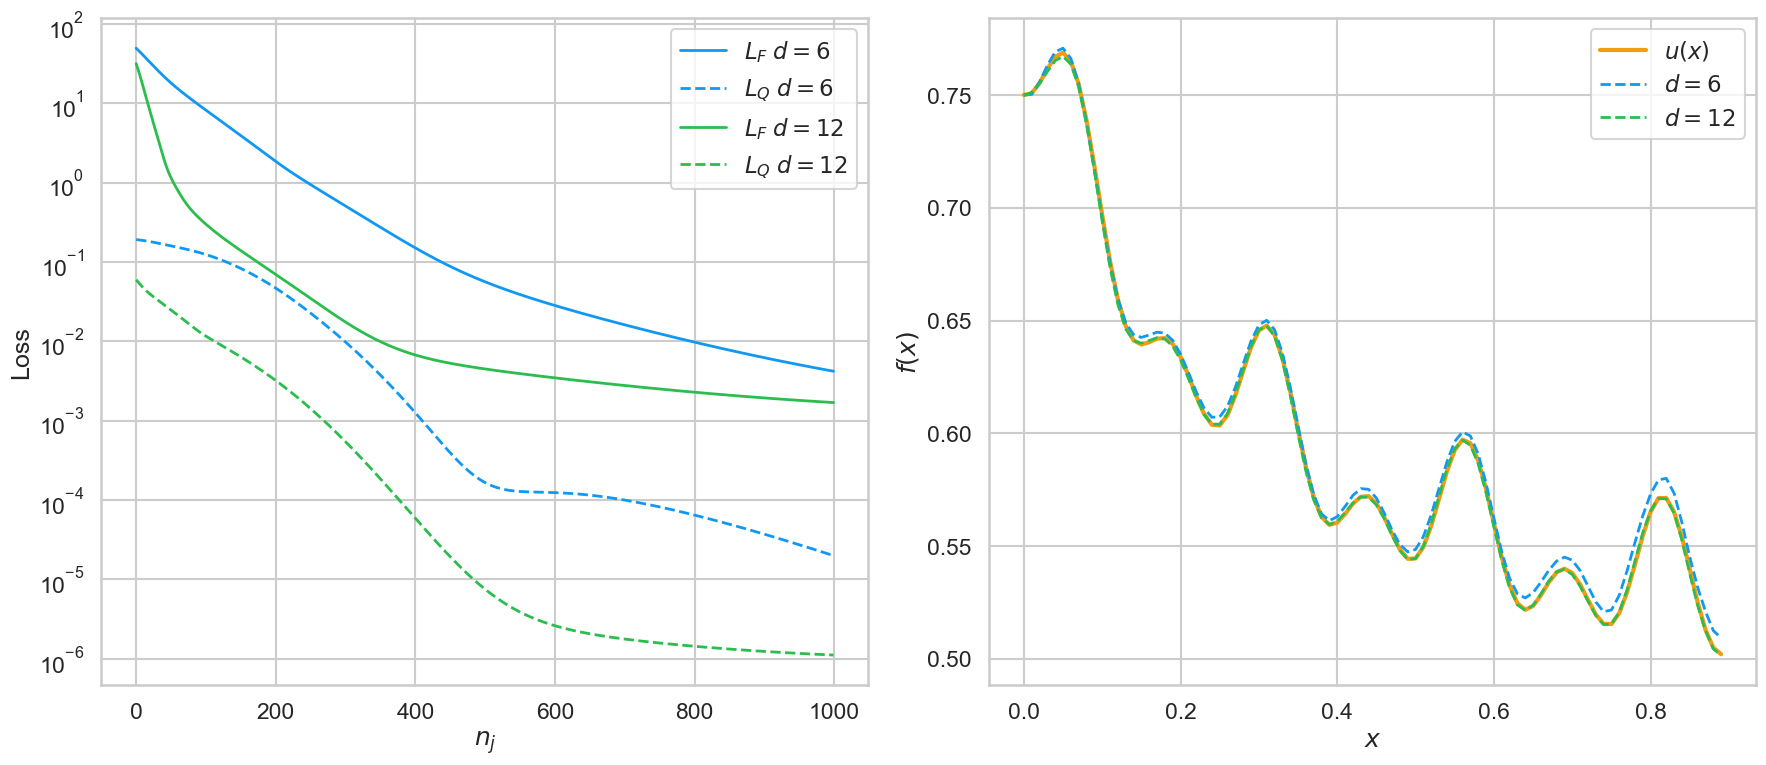

In [90]:
# Test and plot
x_test = torch.arange(xmin, xmax, step=0.01).unsqueeze(1)

plot_results(
    results = [eq32_6, eq32_12],
    labels = [r'$d=6$', r'$d=12$'],
    x_test = x_test,
    solution = solution_eq32
)

factor (alpha) for cost obs = 0.6829523826361351
f(x0) = 0.7500000000000011
diff_loss=38.91434276969691, wgtd_bdry_loss=6.162975822039155e-29
diff_loss=30.349569453865456, wgtd_bdry_loss=1.1422217168843792e-05
diff_loss=23.394653830881854, wgtd_bdry_loss=0.0014440359683842161
diff_loss=17.96390385939493, wgtd_bdry_loss=0.013744335412725186
diff_loss=13.89875757543214, wgtd_bdry_loss=0.043431180583354184
diff_loss=10.96823757147656, wgtd_bdry_loss=0.08434328144093037
diff_loss=8.903298341054416, wgtd_bdry_loss=0.11653303505834922
diff_loss=7.445249151155815, wgtd_bdry_loss=0.11896853940607607
diff_loss=6.38665074773479, wgtd_bdry_loss=0.08782461529129146
diff_loss=5.58266367235934, wgtd_bdry_loss=0.04105194338650572
diff_loss=4.940205202885308, wgtd_bdry_loss=0.006249887255892622
diff_loss=4.40232241088431, wgtd_bdry_loss=0.0030647034412675466
diff_loss=3.9364225088441342, wgtd_bdry_loss=0.03366608348495914
diff_loss=3.524807261933049, wgtd_bdry_loss=0.0853707086897519
diff_loss=3.15792


(process:18508): Pango-WARNING **: 22:57:00.070: couldn't load font "JetBrains Mono Not-Rotated 15", falling back to "Sans Not-Rotated 15", expect ugly output.

(process:18508): Pango-WARNING **: 22:57:00.076: couldn't load font "JetBrains Mono Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(process:18508): Pango-WARNING **: 22:57:00.088: couldn't load font "JetBrains Mono Not-Rotated 13", falling back to "Sans Not-Rotated 13", expect ugly output.


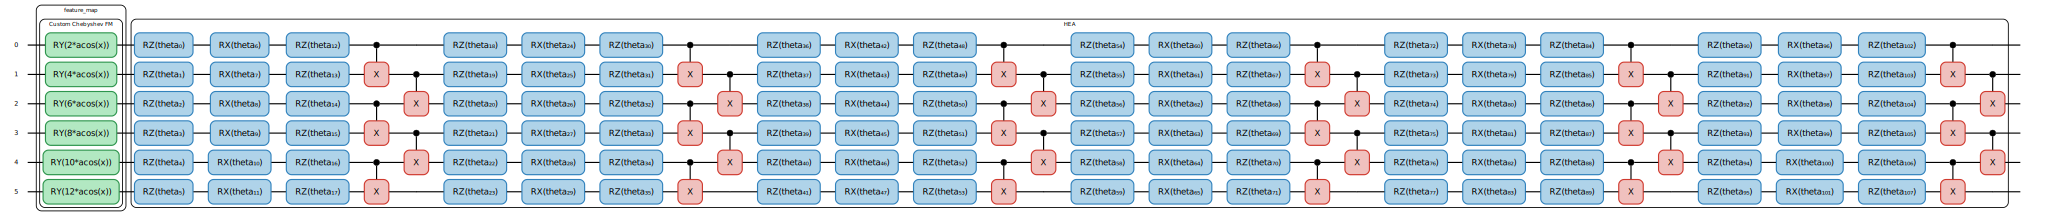

In [79]:
# pretraining for evolution enhanced map
# N = 8, D = 6, epochs = 300, wgt = 5e1, lr = 0.01
n_qubits = 6
depth = 6
cost_obs = qd.hamiltonian_factory(n_qubits, detuning=qd.Z)

torch.manual_seed(1)
pretrain_eq32 = run_dqc_solver(
    functional = functional_eq32,
    u0 = u0_eq32,
    solution_fn = solution_eq32,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = 1,
    n_qubits = n_qubits,
    depth = depth,
    cost_obs = cost_obs,
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq32,
    boundary_loss_weight = 5e1,
    n_epochs = 500,
    lr =  0.01,
    mode = 'pinned'
)

pretrained_param_dict = pretrain_eq32[0]._to_dict(save_params=True)

qd.draw.display(pretrain_eq32[-1])

factor (alpha) for cost obs = 0.294046359790234
f(x0) = 0.7500000000000014
diff_loss=36.003917650738316, wgtd_bdry_loss=1.0415429139246171e-28
diff_loss=28.47422867263676, wgtd_bdry_loss=1.4881028132773823e-05
diff_loss=22.300150818424335, wgtd_bdry_loss=0.001972411636412252
diff_loss=17.31781635877312, wgtd_bdry_loss=0.005135705707447753
diff_loss=13.382093997402325, wgtd_bdry_loss=0.004724721742063872
diff_loss=10.413182730158782, wgtd_bdry_loss=0.0013881098414734148
diff_loss=8.326521241548141, wgtd_bdry_loss=0.0002421419190157181
diff_loss=6.980622430321127, wgtd_bdry_loss=0.006195110437351965
diff_loss=6.165487972621249, wgtd_bdry_loss=0.018809749112069306
diff_loss=5.634634477043214, wgtd_bdry_loss=0.03039284394878926
diff_loss=5.173872260751518, wgtd_bdry_loss=0.032233227018427735
diff_loss=4.664754234654496, wgtd_bdry_loss=0.022893814263406177
diff_loss=4.095645011353083, wgtd_bdry_loss=0.009072916512021184
diff_loss=3.5308968574135617, wgtd_bdry_loss=0.00044700300060904864
dif


(process:20592): Pango-WARNING **: 23:00:15.970: couldn't load font "JetBrains Mono Not-Rotated 15", falling back to "Sans Not-Rotated 15", expect ugly output.

(process:20592): Pango-WARNING **: 23:00:15.997: couldn't load font "JetBrains Mono Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(process:20592): Pango-WARNING **: 23:00:16.007: couldn't load font "JetBrains Mono Not-Rotated 13", falling back to "Sans Not-Rotated 13", expect ugly output.


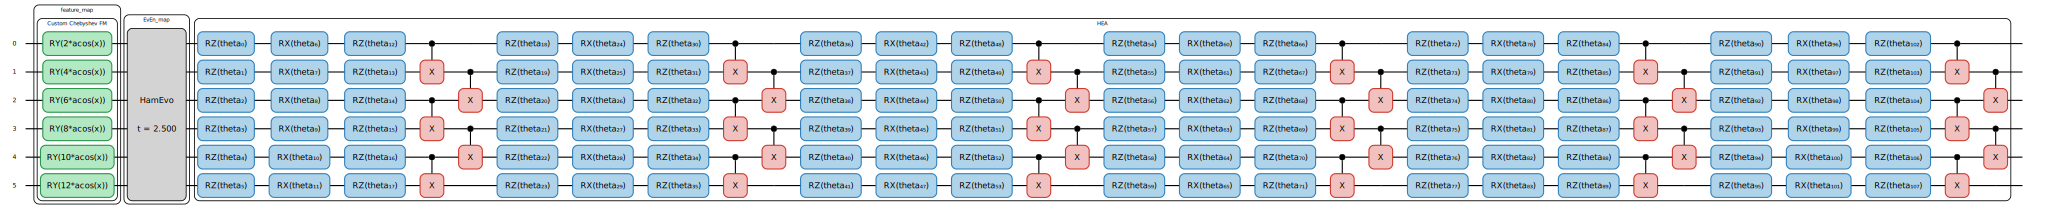

In [80]:
# EvEn map
# N = 8, D = 6, epochs = 300, wgt = 5e1, lr = 0.01, time = ..., score = ...
# (same N, D are required to reuse parameters)
# define T-Ising hamiltonian with random weights
# and `tau = 2.5`
zz_ham = qd.hamiltonian_factory(
    n_qubits,
    interaction=qd.Interaction.ZZ,
    detuning=qd.Z,
    random_strength=True
)
x_ham = qd.hamiltonian_factory(n_qubits, detuning = qd.X, random_strength=True)
transverse_ising = zz_ham + x_ham
tau = 2.5
    
hamevo_eq32 = run_dqc_solver(
    functional = functional_eq32,
    u0 = u0_eq32,
    solution_fn = solution_eq32,
    fm_type = qd.BasisSet.CHEBYSHEV,
    scaling = lambda j: 2 * (j + 1),
    n_layers = 1,
    n_qubits = n_qubits,
    depth = depth,
    cost_obs = cost_obs,
    xmin = xmin,
    xmax = xmax,
    n_points = n_points,
    x0 = x0_eq32,
    boundary_loss_weight = 5e1,
    n_epochs = 500,
    lr =  0.01,
    mode = 'pinned',
    hamevo=(transverse_ising, tau),
    from_dict=pretrained_param_dict
)

qd.draw.display(hamevo_eq32[-1])

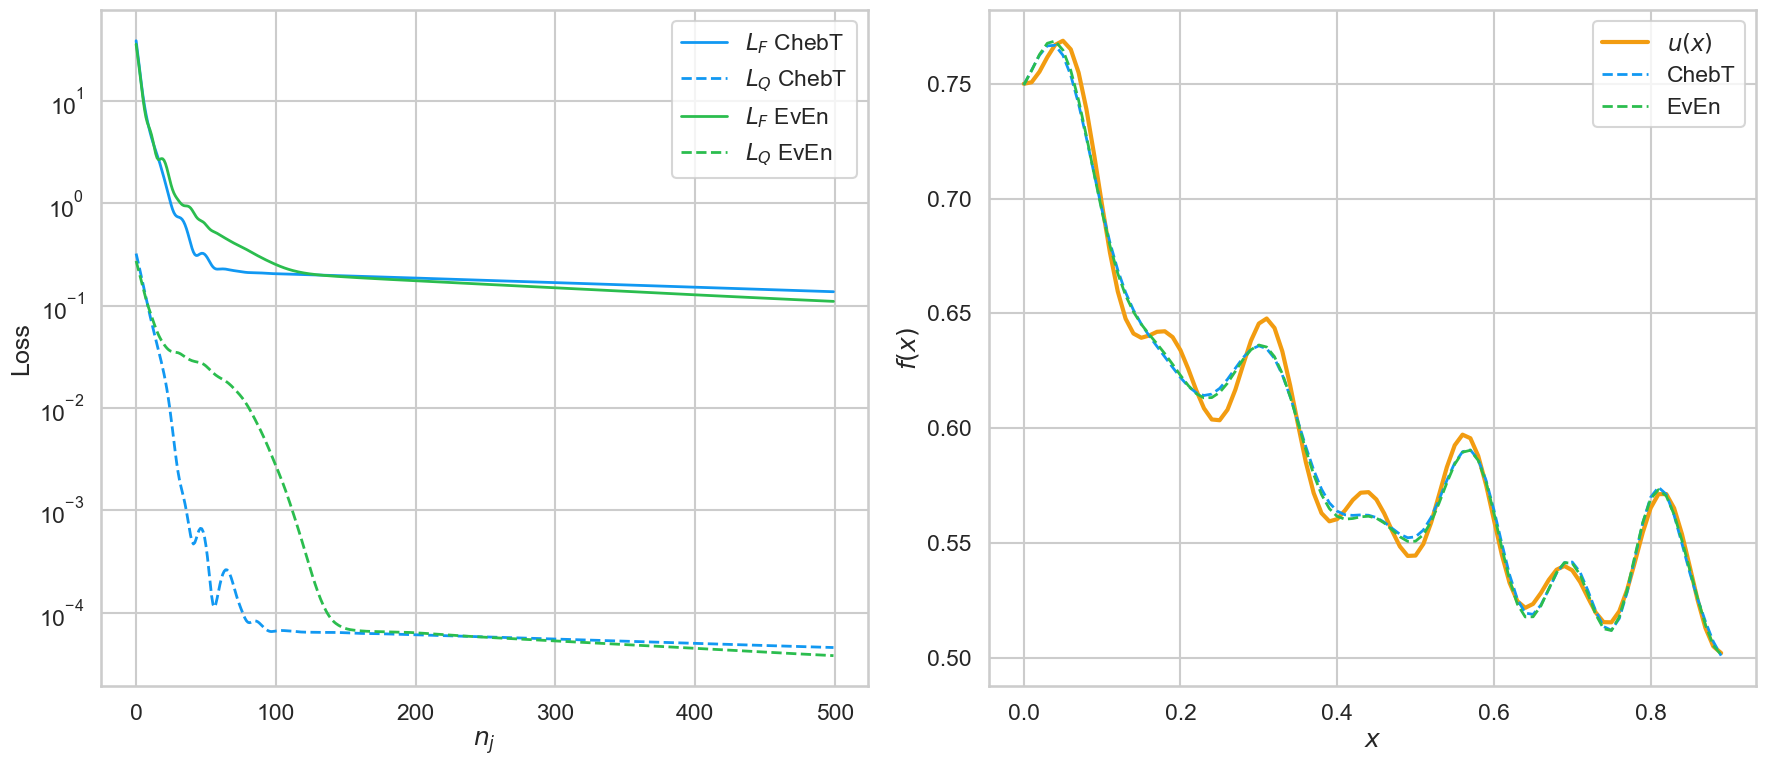

In [81]:
x_test = torch.arange(xmin, xmax, step=0.01).unsqueeze(1)

plot_results(
    results = [pretrain_eq32, hamevo_eq32],
    labels = ['ChebT', 'EvEn'],
    x_test = x_test,
    solution = solution_eq32
)